In [272]:
### Pseudocode

# Phase 1: Truck Route
# Solve truck-only TSP using method of choice (or compare multiple methods) - e.g, nearest neighbor, 2-opt, genetic algorithm
# Formulations are widely available

# Phase 2: Drone Integration
# Start with 1 drone
# Try delivering to each node using a drone instead of the truck separately and compapre savings (similar to Clark-Wright savings)
# Use drone travel time as fraction of truck travel time for simplicity
# If saving found, consider drone meeting truck while en route to next node
# If comfortable, try adding more drones and repeat above steps, including multiple drones delivering to different nodes simultaneously (trucks skipping two or more consecutive nodes in the route sequence)

## TSP: Euclidean distance formulation and plotting

This section formulates a Travelling Salesman Problem using Euclidean distances, solves it (exact for small n, heuristic 2-opt for larger n), and plots the final route.

Usage: run the cells below. The demo cell generates random points, solves the TSP, prints the route length, and shows a matplotlib plot.

In [273]:
# Imports and helper functions
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations


def euclidean_dist(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])


def distance_matrix(points):
    n = len(points)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i][j] = euclidean_dist(points[i], points[j])
    return D


def route_length(route, D):
    s = 0.0
    for k in range(len(route)):
        i = route[k]
        j = route[(k+1) % len(route)]
        s += D[i][j]
    return s


def plot_route(points, route, title=None):
    xs = [points[i][0] for i in route] + [points[route[0]][0]]
    ys = [points[i][1] for i in route] + [points[route[0]][1]]
    plt.figure(figsize=(6,6))
    plt.plot(xs, ys, '-o')
    for idx, (x, y) in enumerate(points):
        plt.text(x, y, str(idx))
    if title:
        plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


In [274]:
# Exact solver for small n and 2-opt heuristic
from itertools import permutations


def tsp_exact(D):
    n = len(D)
    best = None
    best_len = float('inf')
    nodes = list(range(n))
    start = 0
    for perm in permutations(nodes[1:]):
        route = [start] + list(perm)
        l = route_length(route, D)
        if l < best_len:
            best_len = l
            best = route
    return best, best_len


def two_opt(route, D):
    n = len(route)
    improved = True
    best = route[:]
    best_len = route_length(best, D)
    while improved:
        improved = False
        for i in range(1, n-1):
            for j in range(i+1, n):
                if j - i == 1:
                    continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                new_len = route_length(new_route, D)
                if new_len < best_len:
                    best = new_route
                    best_len = new_len
                    improved = True
    return best, best_len


def tsp_solve(points):
    D = distance_matrix(points)
    n = len(points)
    if n <= 10:
        route, l = tsp_exact(D)
        method = 'exact'
    else:
        # nearest neighbor start
        start = 0
        un = set(range(n))
        route = [start]
        un.remove(start)
        while un:
            last = route[-1]
            nxt = min(un, key=lambda x: D[last][x])
            route.append(nxt)
            un.remove(nxt)
        route, l = two_opt(route, D)
        method = '2-opt'
    return route, l, D, method

Method: 2-opt, total length: 432.56
Route: [0, 8, 7, 3, 18, 5, 11, 9, 6, 19, 1, 2, 14, 17, 4, 13, 15, 12, 16, 10]


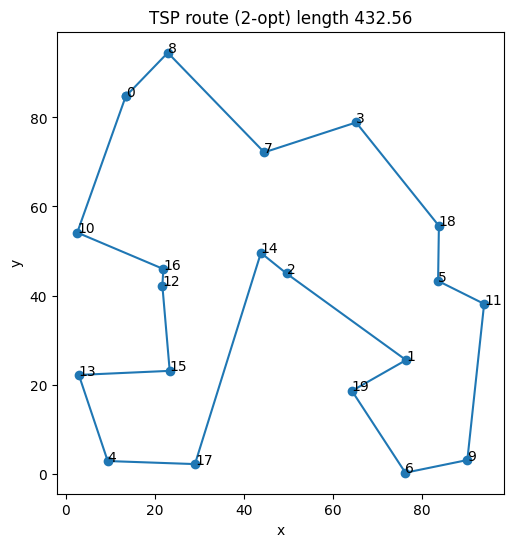

In [361]:
# Demo: generate points, solve, and plot
import random
random.seed(1)

n = 20                            ################### Edit num. points here ##############  # change to <=10 for exact solve; increase for larger tests

to_points = [(random.random()*100, random.random()*100) for _ in range(n)]

to_route, total_len, D, method = tsp_solve(to_points)
print(f"Method: {method}, total length: {total_len:.2f}")
print("Route:", to_route)
plot_route(to_points, to_route, title=f"TSP route ({method}) length {total_len:.2f}")

[0, 8, 7, 3, 18, 5, 11, 1, 9, 6, 19, 2, 14, 16, 12, 15, 17, 4, 13, 10]


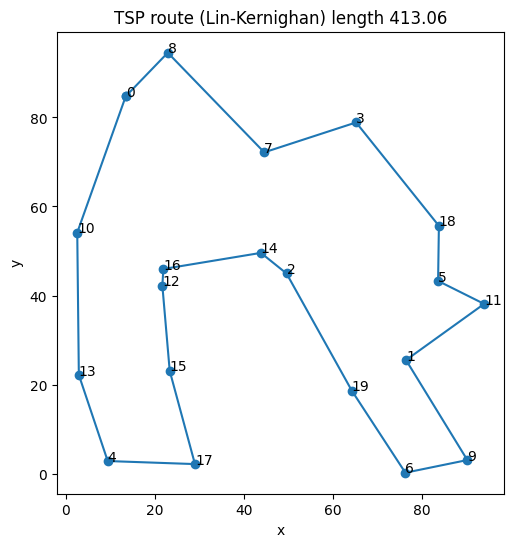

In [363]:
from python_tsp.heuristics import solve_tsp_lin_kernighan


# Demo: generate points, solve, and plot
import random
random.seed(1)

lk_n = 20                          ################### Edit num. points here ##############  # LKH takes a bit longer after 15 for random, 26 for same seed

lk_points = [(random.random()*100, random.random()*100) for _ in range(lk_n)]

lk_D = distance_matrix(lk_points)
lk_route, lk_distance = solve_tsp_lin_kernighan(lk_D)

    
print(lk_route)
plot_route(lk_points, lk_route, title=f"TSP route (Lin-Kernighan) length {lk_distance:.2f}")

In [364]:
import matplotlib.pyplot as plt

def calculate_total_tour_time(points, truck_route, drone_operations, truck_speed=1.0, drone_speed=1.25):         ############## Edit speeds here ############
    """
    Calculate the total tour time including truck travel and drone operations.
    
    Args:
        points (list of tuples): Coordinates of all points.
        truck_route (list of int): Truck route with drone customers already removed.
        drone_operations (list of tuples): [(launch_idx, drone_customer_idx, retrieval_idx), ...]
        truck_speed (float): Speed of the truck.
        drone_speed (float): Speed of the drone.
    
    Returns:
        float: Total tour time.
    """
    D = distance_matrix(points)

    # Calculate base truck time
    truck_time = 0.0
    for i in range(len(truck_route)):
        start = truck_route[i]
        end = truck_route[(i + 1) % len(truck_route)]
        truck_time += D[start][end] / truck_speed

    # Add drone wait times if drone takes longer
    for delivery in drone_operations:
        launch, customer, retrieval = delivery
        drone_time = (D[launch][customer] + D[customer][retrieval]) / drone_speed
        truck_pass_time = D[launch][retrieval] / truck_speed
        if drone_time > truck_pass_time:
            truck_time += drone_time - truck_pass_time
            print(f"Truck waits {drone_time - truck_pass_time:.2f} time for drone to return from customer {customer}")

    return truck_time


def plot_routes_with_drones(points, truck_route, drone_operations):
    """
    Plots the truck and drone routes on a 2D map.
    
    Args:
        points (list of tuples): Coordinates of the points [(x1, y1), (x2, y2), ...].
        truck_route (list of int): Indices of points in the original truck route (including depot).
        drone_operations (list of tuples): [(launch_idx, drone_customer_idx, retrieval_idx), ...]
        truck_speed (float): Speed of the truck.
        drone_speed (float): Speed of the drone.
    """
    # Extract drone customers for removal from truck route
    drone_customers = [op[1] for op in drone_operations]
    
    # Remove drone delivery points from the truck route
    updated_truck_route = [p for p in truck_route if p not in drone_customers]
    
    # Ensure the truck route is cyclic (connects last node back to the first)
    if updated_truck_route[-1] != updated_truck_route[0]:
        updated_truck_route.append(updated_truck_route[0])
    
    # Calculate total tour time
    total_tour_time = calculate_total_tour_time(points, updated_truck_route, drone_operations)
    print(f"\nTotal tour time with drones: {total_tour_time:.2f} time units")
    
    # Plot all points
    x, y = zip(*points)
    plt.scatter(x, y, c='blue', label='Delivery Points', s=100, zorder=3)
    
    # Highlight depot
    plt.scatter([points[0][0]], [points[0][1]], c='red', marker='s', 
                s=150, label='Depot', zorder=4)
    
    # Annotate points with their indices
    for i, (px, py) in enumerate(points):
        plt.text(px + 1, py + 1, str(i), fontsize=9, ha='left')
    
    # Plot truck route
    for i in range(len(updated_truck_route) - 1):
        start, end = updated_truck_route[i], updated_truck_route[i + 1]
        plt.plot([points[start][0], points[end][0]], 
                 [points[start][1], points[end][1]], 
                 'g-', linewidth=2, label='Truck Route' if i == 0 else "", zorder=1)
    
    # Plot drone arcs
    drone_label_added = False
    for launch, drone_cust, retrieval in drone_operations:
        # Launch arc (from truck to customer)
        plt.plot([points[launch][0], points[drone_cust][0]], 
                 [points[launch][1], points[drone_cust][1]], 
                 'r--', linewidth=2, label='Drone Arc' if not drone_label_added else "", zorder=2)
        # Retrieval arc (from customer back to truck)
        plt.plot([points[drone_cust][0], points[retrieval][0]], 
                 [points[drone_cust][1], points[retrieval][1]], 
                 'r--', linewidth=2, zorder=2)
        drone_label_added = True
        
        # Mark drone delivery points distinctly
        plt.scatter([points[drone_cust][0]], [points[drone_cust][1]], 
                   c='orange', marker='^', s=120, zorder=3)
    
    # Add legend and labels
    plt.legend(loc='best')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Truck and Drone Delivery Routes, Tour Time: {total_tour_time:.2f}')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [355]:
def calculate_drone_operations(points, truck_route, drone_range=50.0, truck_speed=1.0, drone_speed=1.25, verbose=True):
    """
    Calculate optimal drone delivery operations for a given truck route.
    
    Args:
        points (list of tuples): Coordinates of all points [(x, y), ...].
        truck_route (list of int): Indices of points in the truck route.
        drone_range (float): Maximum distance a drone can fly (launch + delivery + retrieval).
        truck_speed (float): Speed of the truck.
        drone_speed (float): Speed of the drone.
        verbose (bool): Whether to print detailed information.
    
    Returns:
        list of tuples: Drone operations as [(launch_idx, customer_idx, retrieval_idx), ...]
    """
    # Calculate distance matrix
    D = distance_matrix(points)
    
    if verbose:
        print("=" * 60)
        print("TRUCK ROUTE SEGMENTS:")
        print("=" * 60)
        for i in range(len(truck_route)):
            segment_dist = D[truck_route[i]][truck_route[(i+1)%len(truck_route)]]
            print(f"Segment {truck_route[i]} -> {truck_route[(i+1)%len(truck_route)]}: {segment_dist:.2f}")
        print()
    
    # Calculate savings for each potential drone delivery
    skip_savings = []
    drone_distances = []
    
    for skip_idx in range(len(truck_route)):
        # Calculate savings if this customer is served by drone instead of truck
        prev_customer = truck_route[skip_idx - 1]
        current_customer = truck_route[skip_idx]
        next_customer = truck_route[(skip_idx + 1) % len(truck_route)]
        
        # Truck distance with current customer
        truck_dist_with = (D[prev_customer][current_customer] + 
                          D[current_customer][next_customer])
        
        # Truck distance skipping current customer
        truck_dist_without = D[prev_customer][next_customer]
        
        # Savings (positive means truck saves distance)
        savings = truck_dist_with - truck_dist_without
        
        # Total drone flight distance needed
        drone_dist = (D[prev_customer][current_customer] + 
                     D[current_customer][next_customer])
        
        skip_savings.append((savings, current_customer))
        drone_distances.append(drone_dist)
        
        if verbose:
            print(f"Customer {current_customer}: savings = {savings:.2f}, drone distance = {drone_dist:.2f}")
    
    # Filter by drone range and sort by savings (best first)
    best_drone_deliveries = sorted(
        (skip_savings[i] for i in range(len(truck_route)) 
         if drone_distances[i] <= drone_range),
        reverse=True
    )
    
    if verbose:
        print(f"\n{'=' * 60}")
        print(f"FEASIBLE DRONE DELIVERIES (within range {drone_range:.2f}):")
        print(f"{'=' * 60}")
        for savings, customer in best_drone_deliveries:
            print(f"  Customer {customer}: savings = {savings:.2f}")
    
    # Extract drone customer points
    drone_points = [delivery[1] for delivery in best_drone_deliveries]
    
    # Remove depot if it's in the list (depot should always be visited by truck)
    if 0 in drone_points:
        drone_points.remove(0)
    
    # Ensure no two drone points are adjacent in the truck route
    # (truck needs to travel between launch and retrieval points)
    filtered_drone_points = []
    for point in drone_points:
        # Check if current point is adjacent to any already selected drone point
        is_adjacent = any(
            abs(truck_route.index(point) - truck_route.index(filtered_point)) == 1
            for filtered_point in filtered_drone_points
        )
        # Only add if not adjacent to existing drone deliveries
        if not is_adjacent:
            filtered_drone_points.append(point)
    
    drone_points = filtered_drone_points
    
    # Create drone operations as (launch, customer, retrieval) tuples
    drone_operations = []
    for drone_point in drone_points:
        idx = truck_route.index(drone_point)
        launch = truck_route[idx - 1]  # previous point in route
        retrieval = truck_route[(idx + 1) % len(truck_route)]  # next point (wraps to depot)
        drone_operations.append((launch, drone_point, retrieval))
    
    if verbose:
        print(f"\n{'=' * 60}")
        print(f"SELECTED DRONE OPERATIONS:")
        print(f"{'=' * 60}")
        for op in drone_operations:
            print(f"  Launch from {op[0]}, deliver to {op[1]}, retrieve at {op[2]}")
        print()
    
    return drone_operations


def compare_routes(points, routes_dict, drone_range=50.0, truck_speed=1.0, drone_speed=1.25):
    """
    Compare multiple routing solutions with drone integration.
    
    Args:
        points (list of tuples): Coordinates of all points.
        routes_dict (dict): Dictionary of route name -> route list.
                           e.g., {'Nearest Neighbor': [0,1,2,...], 'LK-Heuristic': [0,3,1,...]}
        drone_range (float): Maximum drone flight distance.
        truck_speed (float): Speed of the truck.
        drone_speed (float): Speed of the drone.
    
    Returns:
        dict: Results for each route with keys 'truck_only_time', 'with_drones_time', 
              'drone_operations', 'improvement_pct'
    """
    D = distance_matrix(points)
    results = {}
    
    print("\n" + "=" * 80)
    print("ROUTE COMPARISON")
    print("=" * 80)
    
    for route_name, truck_route in routes_dict.items():
        print(f"\n{'*' * 80}")
        print(f"ANALYZING: {route_name}")
        print(f"{'*' * 80}")
        
        # Calculate truck-only time
        truck_only_time = 0.0
        for i in range(len(truck_route)):
            start = truck_route[i]
            end = truck_route[(i + 1) % len(truck_route)]
            truck_only_time += D[start][end] / truck_speed
        
        # Get drone operations
        drone_operations = calculate_drone_operations(
            points, truck_route, drone_range, truck_speed, drone_speed, verbose=True
        )
        
        # Calculate time with drones
        drone_customers = [op[1] for op in drone_operations]
        updated_truck_route = [p for p in truck_route if p not in drone_customers]
        
        with_drones_time = calculate_total_tour_time(
            points, updated_truck_route, drone_operations, truck_speed, drone_speed
        )
        
        improvement_pct = ((truck_only_time - with_drones_time) / truck_only_time) * 100
        
        results[route_name] = {
            'truck_only_time': truck_only_time,
            'with_drones_time': with_drones_time,
            'drone_operations': drone_operations,
            'improvement_pct': improvement_pct,
            'num_drone_deliveries': len(drone_operations)
        }
        
        print(f"\nRESULTS for {route_name}:")
        print(f"  Truck-only time: {truck_only_time:.2f}")
        print(f"  With drones time: {with_drones_time:.2f}")
        print(f"  Improvement: {improvement_pct:.2f}%")
        print(f"  Number of drone deliveries: {len(drone_operations)}")
    
    # Summary comparison
    print(f"\n{'=' * 80}")
    print("SUMMARY COMPARISON")
    print(f"{'=' * 80}")
    print(f"{'Method':<25} {'Truck Only':<15} {'With Drones':<15} {'Improvement':<15} {'# Drones'}")
    print("-" * 80)
    for route_name, result in results.items():
        print(f"{route_name:<25} {result['truck_only_time']:>12.2f}   "
              f"{result['with_drones_time']:>12.2f}   "
              f"{result['improvement_pct']:>11.2f}%   "
              f"{result['num_drone_deliveries']:>7}")
    
    return results

TRUCK ROUTE SEGMENTS:
Segment 0 -> 8: 13.60
Segment 8 -> 7: 31.14
Segment 7 -> 3: 21.69
Segment 3 -> 18: 29.76
Segment 18 -> 5: 12.37
Segment 5 -> 11: 11.55
Segment 11 -> 9: 35.26
Segment 9 -> 6: 14.20
Segment 6 -> 19: 21.95
Segment 19 -> 1: 13.98
Segment 1 -> 2: 33.14
Segment 2 -> 14: 7.39
Segment 14 -> 17: 49.69
Segment 17 -> 4: 19.60
Segment 4 -> 13: 20.39
Segment 13 -> 15: 20.42
Segment 15 -> 12: 19.20
Segment 12 -> 16: 3.76
Segment 16 -> 10: 20.99
Segment 10 -> 0: 32.48

Customer 0: savings = 0.86, drone distance = 46.08
Customer 8: savings = 11.18, drone distance = 44.74
Customer 7: savings = 7.74, drone distance = 52.83
Customer 3: savings = 8.89, drone distance = 51.44
Customer 18: savings = 2.05, drone distance = 42.13
Customer 5: savings = 3.67, drone distance = 23.92
Customer 11: savings = 6.07, drone distance = 46.82
Customer 9: savings = 7.63, drone distance = 49.47
Customer 6: savings = 5.94, drone distance = 36.15
Customer 19: savings = 10.63, drone distance = 35.93
Cust

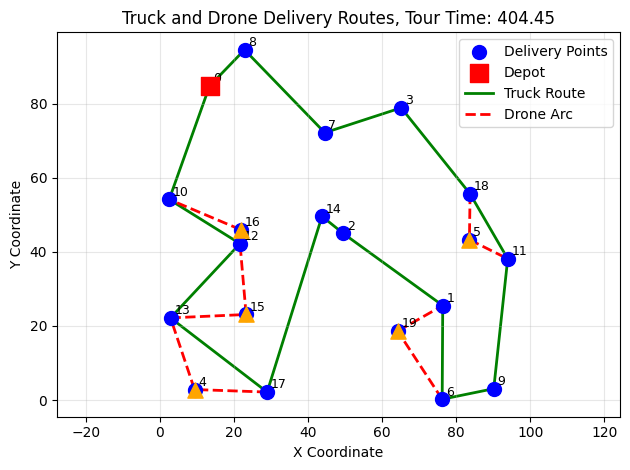

In [365]:
to_drone_ops = calculate_drone_operations(to_points, to_route, drone_range=40.0, verbose=True)
plot_routes_with_drones(to_points, to_route, to_drone_ops)

TRUCK ROUTE SEGMENTS:
Segment 0 -> 8: 13.60
Segment 8 -> 7: 31.14
Segment 7 -> 3: 21.69
Segment 3 -> 18: 29.76
Segment 18 -> 5: 12.37
Segment 5 -> 11: 11.55
Segment 11 -> 1: 21.60
Segment 1 -> 9: 26.33
Segment 9 -> 6: 14.20
Segment 6 -> 19: 21.95
Segment 19 -> 2: 30.17
Segment 2 -> 14: 7.39
Segment 14 -> 16: 22.21
Segment 16 -> 12: 3.76
Segment 12 -> 15: 19.20
Segment 15 -> 17: 21.69
Segment 17 -> 4: 19.60
Segment 4 -> 13: 20.39
Segment 13 -> 10: 31.97
Segment 10 -> 0: 32.48

Customer 0: savings = 0.86, drone distance = 46.08
Customer 8: savings = 11.18, drone distance = 44.74
Customer 7: savings = 7.74, drone distance = 52.83
Customer 3: savings = 8.89, drone distance = 51.44
Customer 18: savings = 2.05, drone distance = 42.13
Customer 5: savings = 3.67, drone distance = 23.92
Customer 11: savings = 13.98, drone distance = 33.16
Customer 1: savings = 12.67, drone distance = 47.93
Customer 9: savings = 15.24, drone distance = 40.54
Customer 6: savings = 5.94, drone distance = 36.15
Cus

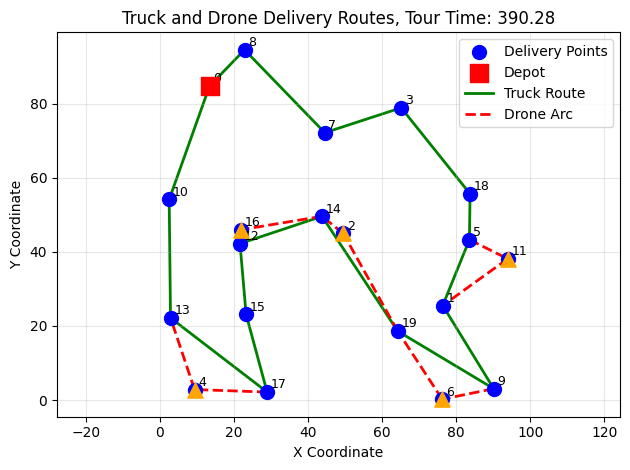

In [360]:
lk_drone_ops = calculate_drone_operations(lk_points, lk_route, drone_range=40.0, verbose=True)
plot_routes_with_drones(lk_points, lk_route, lk_drone_ops)

# Next step if possible: Drone not need to return to next sequential, try two in advance

# Full model attempt (10 point comparison)

In [379]:
import numpy as np
from pulp import *
from pulp import GUROBI_CMD
import matplotlib.pyplot as plt
import random

def distance_matrix(points):
    """Compute Euclidean distance matrix."""
    n = len(points)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.sqrt((points[i][0] - points[j][0])**2 + 
                          (points[i][1] - points[j][1])**2)
            D[i][j] = D[j][i] = dist
    return D

def solve_stdrp_milp_simplified(points, num_drones=2, drone_endurance=100.0, 
                                truck_speed=1.0, drone_speed=1.5, time_limit=300):
    """
    Simplified MILP for Truck-Drone Routing Problem.
    
    Based on Murray & Chu (2015) Flying Sidekick TSP but extended for multiple drones.
    This version is more likely to find solutions quickly.
    
    Args:
        points: List of (x, y) coordinates, with points[0] as depot
        num_drones: Number of available drones (K)
        drone_endurance: Maximum flight time/distance for drones
        truck_speed: Speed of truck
        drone_speed: Speed of drone
        time_limit: Maximum solving time in seconds
    
    Returns:
        Dictionary with solution details
    """
    
    n = len(points)
    D = distance_matrix(points)
    
    # Convert distances to time
    truck_time = D / truck_speed
    drone_time = D / drone_speed
    
    # Sets
    depot = 0
    C = list(range(1, n))  # Customers only
    N = list(range(n))     # All nodes
    
    # Large M value
    M = 1000
    
    print(f"Building simplified MILP model with {n} nodes, {num_drones} drones...")
    print(f"Drone endurance: {drone_endurance:.2f}")
    
    # Create the model
    model = LpProblem("STDRP_Simplified", LpMinimize)
    
    # Decision Variables
    
    # x[i,j]: binary, truck travels from i to j
    x = LpVariable.dicts("x", ((i, j) for i in N for j in N if i != j), cat='Binary')
    
    # y[i,j,k]: binary, drone k delivers to customer i (launched from j, retrieved at next truck stop)
    # Simplified: we track launch point only, retrieval is implicit (next truck location)
    y = LpVariable.dicts("y", ((i, j, k) for i in C for j in N for k in range(num_drones) if i != j), cat='Binary')
    
    # Time variables
    t = LpVariable.dicts("t", N, lowBound=0)  # Arrival time at node i
    
    # Drone return time for synchronization
    drone_return = LpVariable.dicts("drone_return", 
                                   ((i, j, k) for i in C for j in N for k in range(num_drones) if i != j), 
                                   lowBound=0)
    
    # Objective: Minimize total completion time (return to depot)
    model += lpSum(t[depot] + truck_time[i, depot] * x[i, depot] for i in C), "Total_Time"
    
    print("Adding constraints...")
    
    # CONSTRAINT 1: Each customer visited exactly once (by truck OR drone)
    for i in C:
        model += (lpSum(x[j, i] for j in N if j != i) + 
                  lpSum(y[i, j, k] for j in N if j != i for k in range(num_drones)) == 1,
                  f"Visit_{i}")
    
    # CONSTRAINT 2: Flow conservation for truck
    # Leave depot
    model += lpSum(x[depot, j] for j in C) == 1, "Leave_depot"
    
    # Return to depot
    model += lpSum(x[i, depot] for i in C) == 1, "Return_depot"
    
    # Flow balance at each customer visited by truck
    for j in C:
        model += (lpSum(x[i, j] for i in N if i != j) == 
                  lpSum(x[j, i] for i in N if i != j),
                  f"Flow_{j}")
    
    # CONSTRAINT 3: Subtour elimination (MTZ)
    u = LpVariable.dicts("u", C, lowBound=1, upBound=n)
    for i in C:
        for j in C:
            if i != j:
                model += u[i] - u[j] + (n - 1) * x[i, j] <= n - 2, f"MTZ_{i}_{j}"
    
    # CONSTRAINT 4: Drone endurance
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    # For each potential drone delivery, check if it's feasible
                    # We need to ensure drone can fly from j to i and back to any possible next location
                    for next_loc in N:
                        if next_loc != i and next_loc != j:
                            model += (drone_time[j, i] + drone_time[i, next_loc] <= 
                                    drone_endurance + M * (1 - y[i, j, k]) + M * (1 - x[j, next_loc]),
                                    f"Endurance_{i}_{j}_{k}_{next_loc}")
    
    # CONSTRAINT 5: Time propagation for truck
    for i in N:
        for j in N:
            if i != j:
                model += t[j] >= t[i] + truck_time[i, j] - M * (1 - x[i, j]), f"Time_truck_{i}_{j}"
    
    # CONSTRAINT 6: Drone synchronization
    # If drone k delivers to customer i (launched from j), calculate when it returns
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    # Drone launches at time t[j], flies to i and back to next truck location
                    for next_loc in N:
                        if next_loc != i and next_loc != j:
                            # Drone return time = launch time + flight time to customer + flight time back
                            model += (drone_return[i, j, k] >= 
                                    t[j] + drone_time[j, i] + drone_time[i, next_loc] - 
                                    M * (1 - y[i, j, k]) - M * (1 - x[j, next_loc]),
                                    f"Drone_return_{i}_{j}_{k}_{next_loc}")
                            
                            # Truck must wait for drone if drone takes longer
                            model += (t[next_loc] >= drone_return[i, j, k] - 
                                    M * (1 - y[i, j, k]) - M * (1 - x[j, next_loc]),
                                    f"Sync_{i}_{j}_{k}_{next_loc}")
    
    # CONSTRAINT 7: Each drone can only be used once at a time (simplified)
    for k in range(num_drones):
        model += lpSum(y[i, j, k] for i in C for j in N if i != j) <= 1, f"Drone_limit_{k}"
    
    # CONSTRAINT 8: Logical constraint - can only launch drone from truck location
    for i in C:
        for j in C:  # Can only launch from customer locations that truck visits
            if i != j:
                for k in range(num_drones):
                    model += y[i, j, k] <= lpSum(x[m, j] for m in N if m != j), f"Launch_from_truck_{i}_{j}_{k}"
    
    print(f"Model built. Variables: {model.numVariables()}, Constraints: {model.numConstraints()}")
    
    # Solve with Gurobi
    print(f"Solving MILP with Gurobi (time limit: {time_limit}s)...")
    
    solver = GUROBI_CMD(
        timeLimit=time_limit,
        msg=1,
        options=[
            ("MIPGap", 0.10),        # 10% gap is acceptable for initial solution
            ("MIPFocus", 1),          # Focus on finding feasible solutions
            ("Heuristics", 0.3),      # Spend time on heuristics
            ("PreSolve", 2)           # Aggressive presolve
        ]
    )
    
    model.solve(solver)
    
    # Extract solution
    status = LpStatus[model.status]
    print(f"\nSolution Status: {status}")
    
    if status in ['Optimal', 'Feasible']:
        obj_value = value(model.objective)
        print(f"Objective Value (Total Time): {obj_value:.2f}")
        
        # Extract truck route
        truck_route = [depot]
        current = depot
        visited = {depot}
        
        max_iterations = n + 5
        iterations = 0
        
        while len(visited) < n and iterations < max_iterations:
            iterations += 1
            found_next = False
            
            for j in N:
                if j not in visited:
                    if value(x[current, j]) > 0.5:
                        truck_route.append(j)
                        visited.add(j)
                        current = j
                        found_next = True
                        break
            
            if not found_next:
                break
        
        # Extract drone operations
        drone_ops = []
        for i in C:
            for j in N:
                if i != j:
                    for k in range(num_drones):
                        if value(y[i, j, k]) > 0.5:
                            # Find where truck goes after j
                            retrieval = None
                            for next_loc in N:
                                if value(x[j, next_loc]) > 0.5:
                                    retrieval = next_loc
                                    break
                            if retrieval is not None:
                                drone_ops.append((j, i, retrieval, k))
        
        # Calculate truck-only customers
        truck_customers = [node for node in truck_route if node != depot and 
                          node not in [op[1] for op in drone_ops]]
        
        print(f"\nTruck visits {len(truck_customers)} customers directly")
        print(f"Drones deliver to {len(drone_ops)} customers")
        
        return {
            'status': status,
            'objective': obj_value,
            'truck_route': truck_route,
            'drone_operations': drone_ops,
            'model': model
        }
    else:
        print("\n*** No feasible solution found ***")
        print("Try:")
        print("  1. Increasing drone_endurance")
        print("  2. Reducing number of drones")
        print("  3. Increasing time_limit")
        print("  4. Using fewer customers (start with 6-8)")
        return None

def visualize_stdrp_solution(points, solution):
    """Visualize the STDRP solution."""
    if solution is None:
        print("No solution to visualize.")
        return
    
    truck_route = solution['truck_route']
    drone_ops = solution['drone_operations']
    
    plt.figure(figsize=(12, 10))
    
    # Plot all points
    x, y = zip(*points)
    plt.scatter(x, y, c='blue', s=100, zorder=3, label='Customers')
    
    # Highlight depot
    plt.scatter([points[0][0]], [points[0][1]], c='red', marker='s', 
                s=200, label='Depot', zorder=4)
    
    # Annotate points
    for i, (px, py) in enumerate(points):
        plt.text(px + 2, py + 2, str(i), fontsize=11, ha='left', fontweight='bold')
    
    # Plot truck route
    for i in range(len(truck_route) - 1):
        start = truck_route[i]
        end = truck_route[i + 1]
        plt.plot([points[start][0], points[end][0]], 
                 [points[start][1], points[end][1]], 
                 'g-', linewidth=2.5, label='Truck Route' if i == 0 else "", zorder=1)
    
    # Close the loop back to depot if needed
    if truck_route[-1] != 0:
        plt.plot([points[truck_route[-1]][0], points[0][0]], 
                 [points[truck_route[-1]][1], points[0][1]], 
                 'g-', linewidth=2.5, zorder=1)
    
    # Plot drone operations
    colors = ['red', 'orange', 'purple', 'brown', 'pink']
    drone_labels_added = set()
    
    for (launch, customer, retrieval, drone_id) in drone_ops:
        color = colors[drone_id % len(colors)]
        
        # Launch arc
        plt.plot([points[launch][0], points[customer][0]], 
                 [points[launch][1], points[customer][1]], 
                 '--', color=color, linewidth=2.5, 
                 label=f'Drone {drone_id}' if drone_id not in drone_labels_added else "", 
                 zorder=2)
        
        # Retrieval arc
        plt.plot([points[customer][0], points[retrieval][0]], 
                 [points[customer][1], points[retrieval][1]], 
                 '--', color=color, linewidth=2.5, zorder=2)
        
        drone_labels_added.add(drone_id)
        
        # Mark drone delivery
        plt.scatter([points[customer][0]], [points[customer][1]], 
                   c=color, marker='^', s=180, zorder=5, edgecolors='black', linewidths=2)
    
    plt.legend(loc='best', fontsize=11)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.title(f"STDRP Solution - Total Time: {solution['objective']:.2f}", 
             fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate small instance
    random.seed(42)
    n = 8  # Start smaller: 1 depot + 7 customers
    points = [(50, 50)]  # Depot at center
    points += [(random.uniform(20, 80), random.uniform(20, 80)) for _ in range(n-1)]
    
    print(f"Generated {n} points (1 depot + {n-1} customers)")
    
    # Solve STDRP with relaxed parameters
    solution = solve_stdrp_milp_simplified(
        points, 
        num_drones=1,           # Start with just 1 drone
        drone_endurance=80.0,   # Generous endurance
        truck_speed=1.0,
        drone_speed=2.0,        # Drones are 2x faster
        time_limit=120          # 2 minutes
    )
    
    if solution:
        print("\n" + "="*60)
        print("SOLUTION SUMMARY")
        print("="*60)
        print(f"Truck Route: {solution['truck_route']}")
        print(f"\nDrone Operations (launch, customer, retrieval, drone_id):")
        for op in solution['drone_operations']:
            print(f"  Drone {op[3]}: Launch from {op[0]}, deliver to {op[1]}, retrieve at {op[2]}")
        
        # Visualize
        visualize_stdrp_solution(points, solution)
    else:
        print("\nTrying with even simpler parameters...")
        # Retry with more relaxed constraints
        solution = solve_stdrp_milp_simplified(
            points[:6],  # Even fewer customers
            num_drones=1,
            drone_endurance=100.0,
            truck_speed=1.0,
            drone_speed=2.5,
            time_limit=180
        )
        if solution:
            visualize_stdrp_solution(points[:6], solution)

Generated 8 points (1 depot + 7 customers)
Building simplified MILP model with 8 nodes, 1 drones...
Drone endurance: 80.00
Adding constraints...
Model built. Variables: 169, Constraints: 1039
Solving MILP with Gurobi (time limit: 120s)...

Solution Status: Not Solved

*** No feasible solution found ***
Try:
  1. Increasing drone_endurance
  2. Reducing number of drones
  3. Increasing time_limit
  4. Using fewer customers (start with 6-8)

Trying with even simpler parameters...
Building simplified MILP model with 6 nodes, 1 drones...
Drone endurance: 100.00
Adding constraints...
Model built. Variables: 91, Constraints: 383
Solving MILP with Gurobi (time limit: 180s)...

Solution Status: Not Solved

*** No feasible solution found ***
Try:
  1. Increasing drone_endurance
  2. Reducing number of drones
  3. Increasing time_limit
  4. Using fewer customers (start with 6-8)


In [378]:
# Start simple - should solve in < 1 minute
solution = solve_stdrp_milp_simplified(
    points[:8],           # 8 nodes total (1 depot + 7 customers)
    num_drones=1,
    drone_endurance=80.0,
    time_limit=120
)

# If that works, scale up
solution = solve_stdrp_milp_simplified(
    points[:10],          # 10 nodes
    num_drones=2,
    drone_endurance=70.0,
    time_limit=180
)

Building simplified MILP model with 8 nodes, 1 drones...
Drone endurance: 80.00
Adding constraints...
Model built. Variables: 169, Constraints: 1039
Solving MILP with Gurobi (time limit: 120s)...

Solution Status: Not Solved

*** No feasible solution found ***
Try:
  1. Increasing drone_endurance
  2. Reducing number of drones
  3. Increasing time_limit
  4. Using fewer customers (start with 6-8)
Building simplified MILP model with 8 nodes, 2 drones...
Drone endurance: 70.00
Adding constraints...
Model built. Variables: 267, Constraints: 1964
Solving MILP with Gurobi (time limit: 180s)...

Solution Status: Not Solved

*** No feasible solution found ***
Try:
  1. Increasing drone_endurance
  2. Reducing number of drones
  3. Increasing time_limit
  4. Using fewer customers (start with 6-8)


Generated 20 points (1 depot + 19 customers)

Building distance-based MILP: 20 nodes, 2 drones
Drone range: 80.00
Adding constraints...
Model built. Variables: 1140, Constraints: 6403

Solving with Gurobi (time limit: 120s)...

Solution Status: Optimal
Objective Value (Total Truck Distance): 188.10
  Drone 0 delivery to 7: truck waits 17.01
  Drone 1 delivery to 14: truck waits 8.72

Truck visits 17 customers
Drones deliver to 2 customers
Total time (with speeds): 213.82

SOLUTION SUMMARY
Truck Route: [0, 8, 3, 17, 16, 11, 19, 15, 13, 4, 10, 1, 5, 12, 2, 6, 9, 18]

Drone Operations (launch, customer, retrieval, drone_id):
  Drone 0: Launch from 12, deliver to 7, retrieve at 2
  Drone 1: Launch from 2, deliver to 14, retrieve at 6


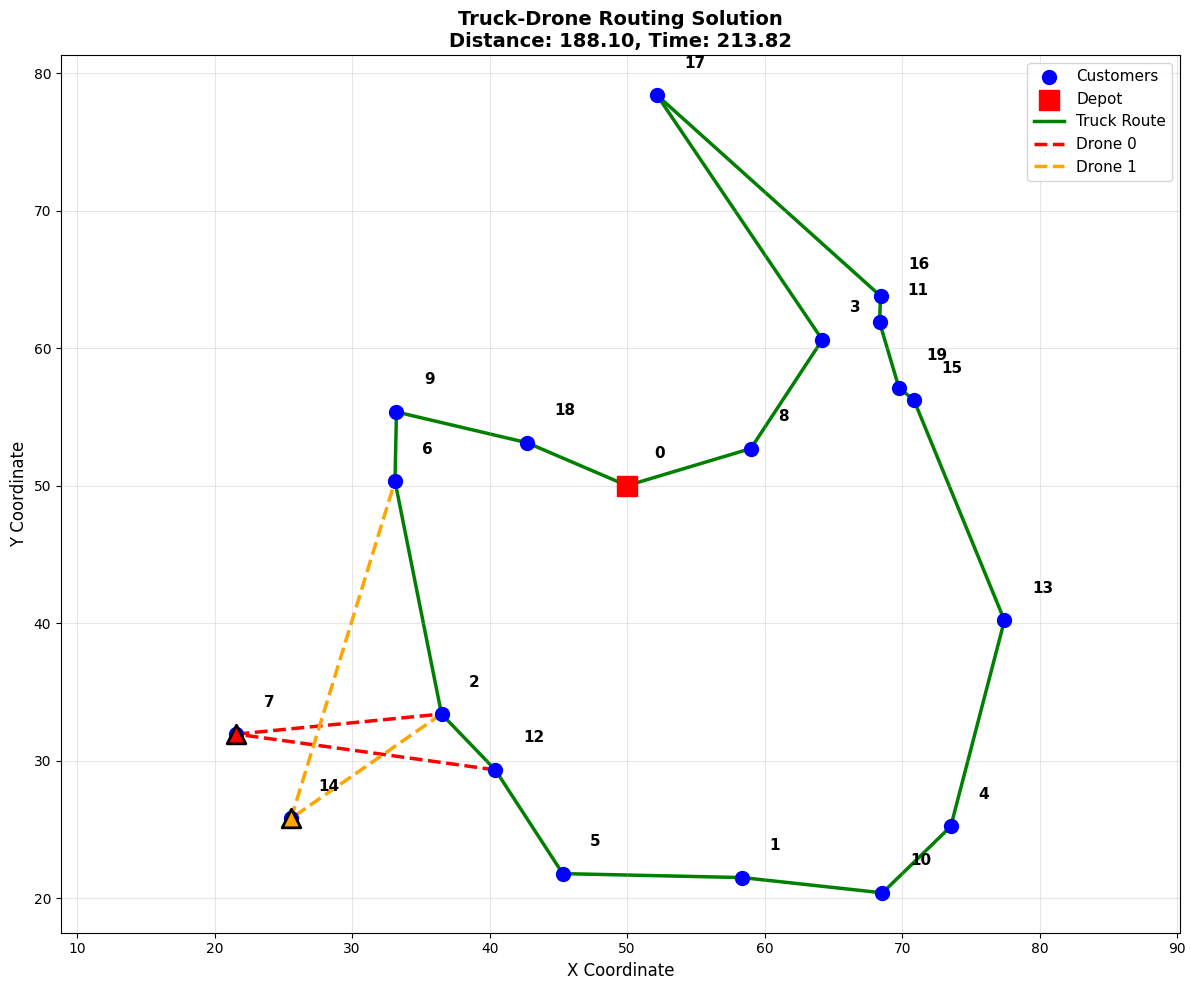

In [384]:
import numpy as np
from pulp import *
from pulp import GUROBI_CMD
import matplotlib.pyplot as plt
import random

def distance_matrix(points):
    """Compute Euclidean distance matrix."""
    n = len(points)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.sqrt((points[i][0] - points[j][0])**2 + 
                          (points[i][1] - points[j][1])**2)
            D[i][j] = D[j][i] = dist
    return D

def solve_tdrp_distance_based(points, num_drones=2, drone_range=80.0, time_limit=180):
    """
    Simplified distance-based MILP for Truck-Drone Routing Problem.
    
    Minimizes total distance traveled, then calculates time afterwards.
    Much simpler and more likely to solve quickly.
    
    Args:
        points: List of (x, y) coordinates, with points[0] as depot
        num_drones: Number of available drones
        drone_range: Maximum distance a drone can fly (out + back)
        time_limit: Maximum solving time in seconds
    
    Returns:
        Dictionary with solution details
    """
    
    n = len(points)
    D = distance_matrix(points)
    
    # Sets
    depot = 0
    C = list(range(1, n))  # Customers only
    N = list(range(n))     # All nodes
    
    # Big M
    M = 1000
    
    print(f"Building distance-based MILP: {n} nodes, {num_drones} drones")
    print(f"Drone range: {drone_range:.2f}")
    
    model = LpProblem("TDRP_Distance", LpMinimize)
    
    # === DECISION VARIABLES ===
    
    # x[i,j]: truck travels from i to j
    x = LpVariable.dicts("x", ((i, j) for i in N for j in N if i != j), cat='Binary')
    
    # served_by_truck[i]: customer i is served by truck (not drone)
    served_by_truck = LpVariable.dicts("truck", C, cat='Binary')
    
    # drone_delivers[i,j,k]: drone k delivers to customer i from truck location j and returns to next truck location
    drone_delivers = LpVariable.dicts("drone", 
                                     ((i, j, k) for i in C for j in N for k in range(num_drones) if i != j), 
                                     cat='Binary')
    
    # === OBJECTIVE: Minimize total distance ===
    # Truck distance + drone distance
    truck_dist = lpSum(D[i][j] * x[i, j] for i in N for j in N if i != j)
    
    # Drone distance: sum of out + back for each drone delivery
    drone_dist = lpSum(
        (D[j][i] + D[i][next_j]) * drone_delivers[i, j, k]
        for i in C 
        for j in N if i != j
        for k in range(num_drones)
        for next_j in N if next_j != i and next_j != j
    )
    
    # Simplified objective: just minimize truck distance (drones save truck distance)
    model += truck_dist, "Total_Distance"
    
    print("Adding constraints...")
    
    # === CONSTRAINTS ===
    
    # C1: Each customer served exactly once (truck OR drone)
    for i in C:
        model += (served_by_truck[i] + 
                  lpSum(drone_delivers[i, j, k] for j in N if j != i for k in range(num_drones)) == 1,
                  f"Serve_{i}")
    
    # C2: If customer served by truck, truck must visit it
    for i in C:
        model += (lpSum(x[j, i] for j in N if j != i) == served_by_truck[i],
                  f"Truck_visit_{i}")
    
    # C3: Truck flow conservation
    model += lpSum(x[depot, j] for j in C) == 1, "Leave_depot"
    model += lpSum(x[i, depot] for i in C) == 1, "Return_depot"
    
    for j in C:
        model += (lpSum(x[i, j] for i in N if i != j) == 
                  lpSum(x[j, i] for i in N if i != j),
                  f"Flow_{j}")
    
    # C4: Subtour elimination (MTZ) - only for customers visited by truck
    u = LpVariable.dicts("u", C, lowBound=0, upBound=n)
    for i in C:
        for j in C:
            if i != j:
                model += (u[i] - u[j] + n * x[i, j] <= n - 1 + M * (1 - served_by_truck[i]) + M * (1 - served_by_truck[j]),
                         f"MTZ_{i}_{j}")
    
    # C5: Drone range constraint - simplified version
    # Drone can only deliver if total distance (launch to customer to retrieval) <= range
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    # Maximum possible drone trip from any location
                    max_drone_dist = max(D[j][i] + D[i][m] for m in N if m != i)
                    if max_drone_dist > drone_range:
                        # If even the best case violates range, forbid this delivery
                        model += drone_delivers[i, j, k] == 0, f"Range_forbid_{i}_{j}_{k}"
                    else:
                        # Add constraint that checks against actual next location
                        for next_j in N:
                            if next_j != i and next_j != j:
                                model += (D[j][i] + D[i][next_j] <= 
                                        drone_range + M * (1 - drone_delivers[i, j, k]) + M * (1 - x[j, next_j]),
                                        f"Range_{i}_{j}_{k}_{next_j}")
    
    # C6: Drone can only launch from truck location
    for i in C:
        for j in C:  # Only from customer locations (truck must visit)
            if i != j:
                for k in range(num_drones):
                    model += drone_delivers[i, j, k] <= served_by_truck[j], f"Launch_{i}_{j}_{k}"
    
    # C7: Each drone used at most once
    for k in range(num_drones):
        model += lpSum(drone_delivers[i, j, k] for i in C for j in N if i != j) <= 1, f"Drone_once_{k}"
    
    # C8: Can't launch drone from depot (simplified - optional constraint)
    for i in C:
        for k in range(num_drones):
            model += drone_delivers[i, depot, k] == 0, f"No_depot_launch_{i}_{k}"
    
    print(f"Model built. Variables: {model.numVariables()}, Constraints: {model.numConstraints()}")
    
    # Solve
    print(f"\nSolving with Gurobi (time limit: {time_limit}s)...")
    
    solver = GUROBI_CMD(
        timeLimit=time_limit,
        msg=1,
        options=[
            ("MIPGap", 0.10),
            ("MIPFocus", 1),
            ("Heuristics", 0.5)
        ]
    )
    
    model.solve(solver)
    
    status = LpStatus[model.status]
    print(f"\nSolution Status: {status}")
    
    if status not in ['Optimal', 'Feasible']:
        print("\n*** No solution found ***")
        return None
    
    obj_value = value(model.objective)
    print(f"Objective Value (Total Truck Distance): {obj_value:.2f}")
    
    # Extract truck route
    truck_route = [depot]
    current = depot
    visited = {depot}
    
    for _ in range(n):
        for j in N:
            if j not in visited and value(x.get((current, j), 0)) > 0.5:
                truck_route.append(j)
                visited.add(j)
                current = j
                break
        else:
            break
    
    # Extract drone operations
    drone_ops = []
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    if value(drone_delivers.get((i, j, k), 0)) > 0.5:
                        # Find retrieval point
                        retrieval = None
                        for next_j in N:
                            if next_j != i and next_j != j and value(x.get((j, next_j), 0)) > 0.5:
                                retrieval = next_j
                                break
                        if retrieval:
                            drone_ops.append((j, i, retrieval, k))
    
    # Calculate actual time with speeds
    truck_speed = 1.0
    drone_speed = 1.5
    
    total_time = calculate_tour_time_milp(points, truck_route, drone_ops, truck_speed, drone_speed)
    
    print(f"\nTruck visits {len([i for i in truck_route if i != depot])} customers")
    print(f"Drones deliver to {len(drone_ops)} customers")
    print(f"Total time (with speeds): {total_time:.2f}")
    
    return {
        'status': status,
        'objective_distance': obj_value,
        'total_time': total_time,
        'truck_route': truck_route,
        'drone_operations': drone_ops,
        'model': model
    }

def calculate_tour_time_milp(points, truck_route, drone_ops, truck_speed=1.0, drone_speed=1.5):
    """Calculate actual tour time considering truck and drone speeds."""
    D = distance_matrix(points)
    
    # Get drone customers
    drone_customers = [op[1] for op in drone_ops]
    
    # Remove drone customers from truck route
    truck_route_actual = [node for node in truck_route if node not in drone_customers]
    
    # Calculate truck time
    truck_time = 0.0
    for i in range(len(truck_route_actual)):
        start = truck_route_actual[i]
        end = truck_route_actual[(i + 1) % len(truck_route_actual)]
        truck_time += D[start][end] / truck_speed
    
    # Add waiting time for drones
    for launch, customer, retrieval, drone_id in drone_ops:
        drone_flight_time = (D[launch][customer] + D[customer][retrieval]) / drone_speed
        truck_segment_time = D[launch][retrieval] / truck_speed
        
        if drone_flight_time > truck_segment_time:
            wait_time = drone_flight_time - truck_segment_time
            truck_time += wait_time
            print(f"  Drone {drone_id} delivery to {customer}: truck waits {wait_time:.2f}")
    
    return truck_time

def visualize_stdrp_solution(points, solution):
    """Visualize the STDRP solution."""
    if solution is None:
        print("No solution to visualize.")
        return
    
    truck_route = solution['truck_route']
    drone_ops = solution['drone_operations']
    
    plt.figure(figsize=(12, 10))
    
    # Plot all points
    x, y = zip(*points)
    plt.scatter(x, y, c='blue', s=100, zorder=3, label='Customers')
    
    # Highlight depot
    plt.scatter([points[0][0]], [points[0][1]], c='red', marker='s', 
                s=200, label='Depot', zorder=4)
    
    # Annotate points
    for i, (px, py) in enumerate(points):
        plt.text(px + 2, py + 2, str(i), fontsize=11, ha='left', fontweight='bold')
    
    # Plot truck route
    for i in range(len(truck_route)):
        start = truck_route[i]
        end = truck_route[(i + 1) % len(truck_route)]
        plt.plot([points[start][0], points[end][0]], 
                 [points[start][1], points[end][1]], 
                 'g-', linewidth=2.5, label='Truck Route' if i == 0 else "", zorder=1)
    
    # Plot drone operations
    colors = ['red', 'orange', 'purple', 'brown', 'pink']
    drone_labels_added = set()
    
    for (launch, customer, retrieval, drone_id) in drone_ops:
        color = colors[drone_id % len(colors)]
        
        # Launch arc
        plt.plot([points[launch][0], points[customer][0]], 
                 [points[launch][1], points[customer][1]], 
                 '--', color=color, linewidth=2.5, 
                 label=f'Drone {drone_id}' if drone_id not in drone_labels_added else "", 
                 zorder=2)
        
        # Retrieval arc
        plt.plot([points[customer][0], points[retrieval][0]], 
                 [points[customer][1], points[retrieval][1]], 
                 '--', color=color, linewidth=2.5, zorder=2)
        
        drone_labels_added.add(drone_id)
        
        # Mark drone delivery
        plt.scatter([points[customer][0]], [points[customer][1]], 
                   c=color, marker='^', s=180, zorder=5, edgecolors='black', linewidths=2)
    
    plt.legend(loc='best', fontsize=11)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.title(f"Truck-Drone Routing Solution\nDistance: {solution['objective_distance']:.2f}, Time: {solution['total_time']:.2f}", 
             fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate small instance
    random.seed(42)
    n = 20  # 1 depot + 9 customers
    points = [(50, 50)]  # Depot at center
    points += [(random.uniform(20, 80), random.uniform(20, 80)) for _ in range(n-1)]
    
    print(f"Generated {n} points (1 depot + {n-1} customers)\n")
    
    # Solve with distance-based model
    solution = solve_tdrp_distance_based(
        points, 
        num_drones=2,
        drone_range=80.0,    # Max distance for drone round trip
        time_limit=120
    )
    
    if solution:
        print("\n" + "="*70)
        print("SOLUTION SUMMARY")
        print("="*70)
        print(f"Truck Route: {solution['truck_route']}")
        print(f"\nDrone Operations (launch, customer, retrieval, drone_id):")
        for op in solution['drone_operations']:
            print(f"  Drone {op[3]}: Launch from {op[0]}, deliver to {op[1]}, retrieve at {op[2]}")
        
        # Visualize
        visualize_stdrp_solution(points, solution)

Generated 10 points (1 depot + 9 customers)

Building distance-based MILP: 10 nodes, 2 drones
Drone range: 80.00
Adding constraints...
  Constraint C1: Each of 9 customers must be served exactly once
Model built. Variables: 270, Constraints: 1259
  C1 (serve each customer): 9 constraints
  C2 (truck visit if served): 9 constraints
  C7 (sequential drone limit): ~200 constraints

Solving with Gurobi (time limit: 120s)...

Solution Status: Optimal
Objective Value (Total Time - Approx): 94.93

SOLVER DECISIONS FOR EACH CUSTOMER:
Customer 1: served_by_truck=1.00, total_drone_delivers=0.00
Customer 2: served_by_truck=1.00, total_drone_delivers=0.00
Customer 3: served_by_truck=0.00, total_drone_delivers=1.00
  -> drone_delivers[3,0,1] = 1.00
Customer 4: served_by_truck=0.00, total_drone_delivers=1.00
  -> drone_delivers[4,1,0] = 1.00
Customer 5: served_by_truck=1.00, total_drone_delivers=0.00
Customer 6: served_by_truck=0.00, total_drone_delivers=1.00
  -> drone_delivers[6,2,1] = 1.00
Custom

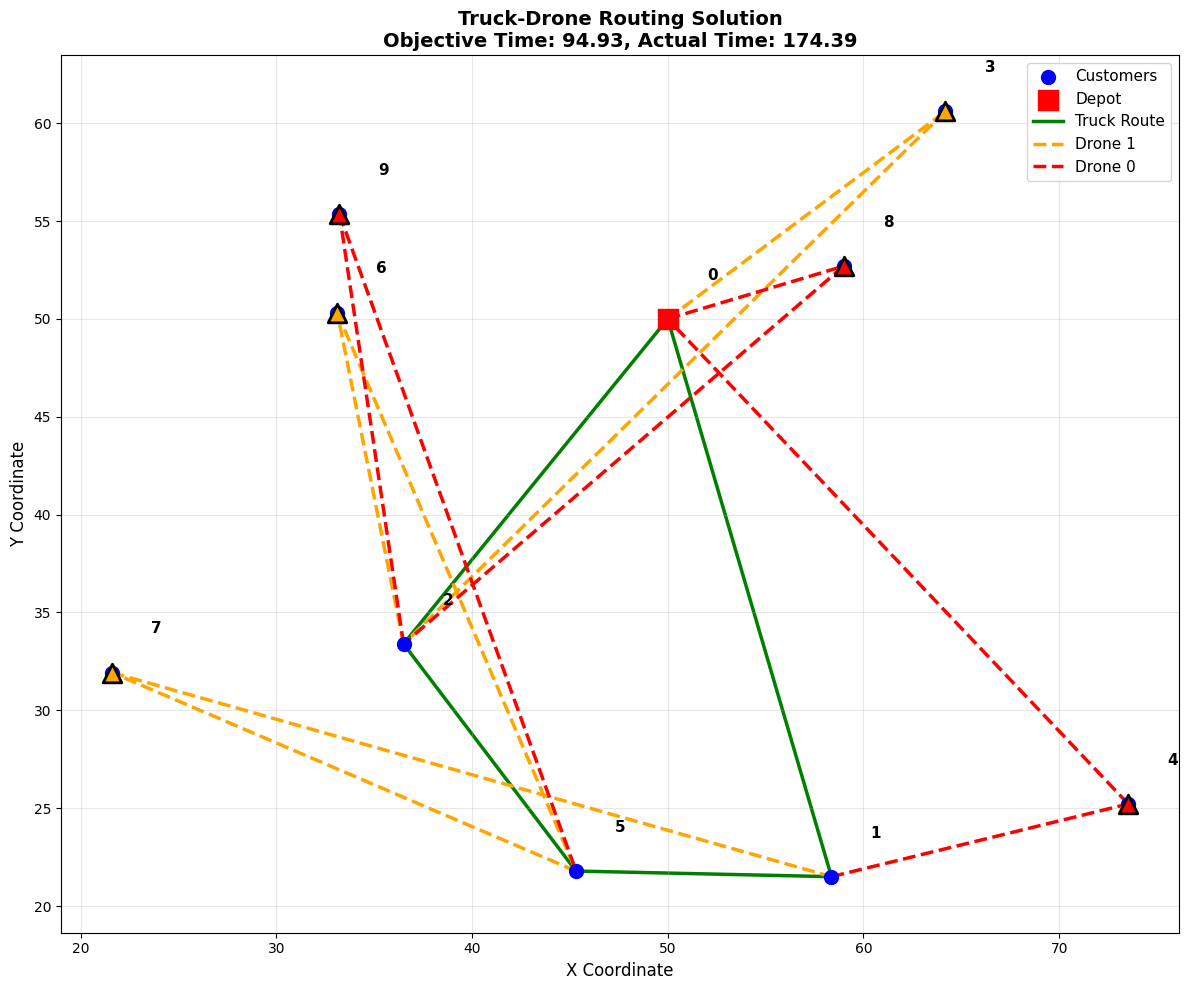

In [438]:
import numpy as np
from pulp import *
from pulp import GUROBI_CMD
import matplotlib.pyplot as plt
import random

def distance_matrix(points):
    """Compute Euclidean distance matrix."""
    n = len(points)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.sqrt((points[i][0] - points[j][0])**2 + 
                          (points[i][1] - points[j][1])**2)
            D[i][j] = D[j][i] = dist
    return D

def solve_tdrp_distance_based(points, num_drones=2, drone_range=80.0, 
                              truck_speed=1.0, drone_speed=1.5, time_limit=180):
    """
    Simplified distance-based MILP for Truck-Drone Routing Problem.
    
    Minimizes total time (distance/speed), then calculates detailed time afterwards.
    Much simpler and more likely to solve quickly.
    
    Args:
        points: List of (x, y) coordinates, with points[0] as depot
        num_drones: Number of available drones
        drone_range: Maximum distance a drone can fly (out + back)
        truck_speed: Speed of truck
        drone_speed: Speed of drone
        time_limit: Maximum solving time in seconds
    
    Returns:
        Dictionary with solution details
    """
    
    n = len(points)
    D = distance_matrix(points)
    
    # Sets
    depot = 0
    C = list(range(1, n))  # Customers only
    N = list(range(n))     # All nodes
    
    # Big M
    M = 1000
    
    print(f"Building distance-based MILP: {n} nodes, {num_drones} drones")
    print(f"Drone range: {drone_range:.2f}")
    
    model = LpProblem("TDRP_Distance", LpMinimize)
    
    # === DECISION VARIABLES ===
    
    # x[i,j]: truck travels from i to j
    x = LpVariable.dicts("x", ((i, j) for i in N for j in N if i != j), cat='Binary')
    
    # served_by_truck[i]: customer i is served by truck (not drone)
    served_by_truck = LpVariable.dicts("truck", C, cat='Binary')
    
    # drone_delivers[i,j,k]: drone k delivers to customer i from truck location j and returns to next truck location
    drone_delivers = LpVariable.dicts("drone", 
                                     ((i, j, k) for i in C for j in N for k in range(num_drones) if i != j), 
                                     cat='Binary')
    
    # === OBJECTIVE: Minimize total time (distance/speed) ===
    # Truck time: distance / truck_speed
    truck_time_obj = lpSum(D[i][j] / truck_speed * x[i, j] for i in N for j in N if i != j)
    
    # Drone time: For each drone delivery, it takes max(truck_time, drone_time) for that segment
    # We approximate this by adding the drone distance/speed weighted by a factor
    # This encourages using drones when they're faster
    drone_time_obj = lpSum(
        (D[j][i] / drone_speed + D[i][next_j] / drone_speed) * drone_delivers[i, j, k]
        for i in C 
        for j in N if i != j
        for k in range(num_drones)
        for next_j in N if next_j != i and next_j != j
    )
    
    # Objective: minimize total time
    # Weight the drone time very small to account for parallelism (drones work while truck drives)
    # Lower weight encourages more drone usage
    model += truck_time_obj + 0.01 * drone_time_obj, "Total_Time"
    
    print("Adding constraints...")
    
    # === CONSTRAINTS ===
    
    # C1: Each customer served exactly once (truck OR drone)
    for i in C:
        model += (served_by_truck[i] + 
                  lpSum(drone_delivers[i, j, k] for j in N if j != i for k in range(num_drones)) == 1,
                  f"Serve_{i}")
    
    print(f"  Constraint C1: Each of {len(C)} customers must be served exactly once")
    
    # C2: If customer served by truck, truck must visit it
    for i in C:
        model += (lpSum(x[j, i] for j in N if j != i) == served_by_truck[i],
                  f"Truck_visit_{i}")
    
    # C3: Truck flow conservation
    model += lpSum(x[depot, j] for j in C) == 1, "Leave_depot"
    model += lpSum(x[i, depot] for i in C) == 1, "Return_depot"
    
    for j in C:
        model += (lpSum(x[i, j] for i in N if i != j) == 
                  lpSum(x[j, i] for i in N if i != j),
                  f"Flow_{j}")
    
    # C4: Subtour elimination (MTZ) - only for customers visited by truck
    u = LpVariable.dicts("u", C, lowBound=0, upBound=n)
    for i in C:
        for j in C:
            if i != j:
                model += (u[i] - u[j] + n * x[i, j] <= n - 1 + M * (1 - served_by_truck[i]) + M * (1 - served_by_truck[j]),
                         f"MTZ_{i}_{j}")
    
    # C5: Drone range constraint - simplified version
    # Drone can only deliver if total distance (launch to customer to retrieval) <= range
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    # Maximum possible drone trip from any location
                    max_drone_dist = max(D[j][i] + D[i][m] for m in N if m != i)
                    if max_drone_dist > drone_range:
                        # If even the best case violates range, forbid this delivery
                        model += drone_delivers[i, j, k] == 0, f"Range_forbid_{i}_{j}_{k}"
                    else:
                        # Add constraint that checks against actual next location
                        for next_j in N:
                            if next_j != i and next_j != j:
                                model += (D[j][i] + D[i][next_j] <= 
                                        drone_range + M * (1 - drone_delivers[i, j, k]) + M * (1 - x[j, next_j]),
                                        f"Range_{i}_{j}_{k}_{next_j}")
    
    # C6: Drone can only launch from truck location (including depot)
    for i in C:
        for j in C:  # Only from customer locations (truck must visit)
            if i != j:
                for k in range(num_drones):
                    model += drone_delivers[i, j, k] <= served_by_truck[j], f"Launch_{i}_{j}_{k}"
    
    # Drones can also launch from depot (depot is always visited)
    # No additional constraint needed for depot launches
    
    # C7: Each drone can make multiple deliveries (removed single-use constraint)
    # Instead, ensure no consecutive deliveries without truck rendezvous
    # A drone can deliver to customer i1 from truck location j1, then later deliver to i2 from j2
    # as long as j1 and j2 are different (truck has moved between deliveries)
    
    # For each pair of consecutive truck stops, same drone can only do one delivery
    for k in range(num_drones):
        for j in N:
            for next_j in N:
                if j != next_j:
                    # Between truck locations j and next_j, drone k can deliver at most once
                    # Only apply constraint if x[j, next_j] == 1
                    model += (lpSum(drone_delivers.get((i, j, k), 0) for i in C if i != j and i != next_j) 
                             <= 1 + M * (1 - x.get((j, next_j), 0)),
                             f"Drone_sequential_{k}_{j}_{next_j}")
    
    # C8: Depot cannot be a drone delivery destination
    # (Drones can launch FROM and return TO depot, but depot is not a customer)
    # This is implicitly satisfied since depot is not in C (customer set)
    
    print(f"Model built. Variables: {model.numVariables()}, Constraints: {model.numConstraints()}")
    
    # Debug: print constraint summary
    print(f"  C1 (serve each customer): {len(C)} constraints")
    print(f"  C2 (truck visit if served): {len(C)} constraints")
    print(f"  C7 (sequential drone limit): ~{len(N) * len(N) * num_drones} constraints")
    
    # Solve
    print(f"\nSolving with Gurobi (time limit: {time_limit}s)...")
    
    solver = GUROBI_CMD(
        timeLimit=time_limit,
        msg=1,
        options=[
            ("MIPGap", 0.10),
            ("MIPFocus", 1),
            ("Heuristics", 0.5)
        ]
    )
    
    model.solve(solver)
    
    status = LpStatus[model.status]
    print(f"\nSolution Status: {status}")
    
    if status not in ['Optimal', 'Feasible']:
        print("\n*** No solution found ***")
        return None
    
    obj_value = value(model.objective)
    print(f"Objective Value (Total Time - Approx): {obj_value:.2f}")
    
    # DEBUG: Check what the solver actually decided for each customer
    print("\n" + "="*70)
    print("SOLVER DECISIONS FOR EACH CUSTOMER:")
    print("="*70)
    for i in C:
        truck_val = value(served_by_truck[i])
        drone_vals = {}
        for j in N:
            if i != j:
                for k in range(num_drones):
                    val = value(drone_delivers.get((i, j, k), 0))
                    if val > 0.1:
                        drone_vals[(j, k)] = val
        
        total_drone = sum(drone_vals.values())
        print(f"Customer {i}: served_by_truck={truck_val:.2f}, total_drone_delivers={total_drone:.2f}")
        if drone_vals:
            for (j, k), val in drone_vals.items():
                print(f"  -> drone_delivers[{i},{j},{k}] = {val:.2f}")
    print("="*70 + "\n")
    
    # Extract truck route (need to extract as a cycle to handle wrap-around)
    truck_route = [depot]
    current = depot
    visited = {depot}
    
    # Build the route following the edges
    for _ in range(n):
        for j in N:
            if j not in visited and value(x.get((current, j), 0)) > 0.5:
                truck_route.append(j)
                visited.add(j)
                current = j
                break
        else:
            break
    
    # Create a mapping of truck route order for wrap-around checks
    truck_route_map = {node: idx for idx, node in enumerate(truck_route)}
    
    print(f"Truck route (linear): {truck_route}")
    print(f"Truck route length: {len(truck_route)} nodes")
    
    # Verify all customers are served
    drone_customers = set()
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    if value(drone_delivers.get((i, j, k), 0)) > 0.5:
                        drone_customers.add(i)
    
    truck_customers = set(truck_route) - {depot}
    all_served = truck_customers | drone_customers
    
    if len(all_served) != len(C):
        print(f"WARNING: Not all customers served!")
        print(f"  Truck serves: {sorted(truck_customers)}")
        print(f"  Drones serve: {sorted(drone_customers)}")
        print(f"  Missing: {sorted(set(C) - all_served)}")
        print(f"  Duplicate: {sorted(truck_customers & drone_customers)}")
        
        # Debug: Check the constraint values for missing customers
        for missing in sorted(set(C) - all_served):
            truck_val = value(served_by_truck[missing])
            drone_val = sum(value(drone_delivers.get((missing, j, k), 0)) 
                          for j in N if j != missing for k in range(num_drones))
            total = truck_val + drone_val
            print(f"  Customer {missing}: served_by_truck={truck_val:.2f}, drone_delivers={drone_val:.2f}, total={total:.2f}")
            
            # Check if it's within drone range from any location
            print(f"    Checking drone feasibility for customer {missing}:")
            for j in N:
                if j != missing:
                    min_return_dist = min(D[missing][m] for m in N if m != missing)
                    total_drone_dist = D[j][missing] + min_return_dist
                    print(f"      From {j}: launch_dist={D[j][missing]:.2f}, min_return={min_return_dist:.2f}, total={total_drone_dist:.2f}, feasible={total_drone_dist <= drone_range}")
    
    # Extract drone operations
    drone_ops = []
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    if value(drone_delivers.get((i, j, k), 0)) > 0.5:
                        # Find retrieval point
                        retrieval = None
                        for next_j in N:
                            if next_j != i and next_j != j and value(x.get((j, next_j), 0)) > 0.5:
                                retrieval = next_j
                                break
                        if retrieval is not None:
                            drone_ops.append((j, i, retrieval, k))
    
    # Calculate actual time with speeds
    truck_speed = 1.0
    drone_speed = 1.5
    
    total_time = calculate_tour_time_milp(points, truck_route, drone_ops, truck_speed, drone_speed)
    
    print(f"\nTruck visits {len([i for i in truck_route if i != depot])} customers")
    print(f"Drones deliver to {len(drone_ops)} customers")
    
    # Count deliveries per drone
    drone_delivery_count = {}
    for op in drone_ops:
        drone_id = op[3]
        drone_delivery_count[drone_id] = drone_delivery_count.get(drone_id, 0) + 1
    
    for drone_id, count in sorted(drone_delivery_count.items()):
        print(f"  Drone {drone_id}: {count} deliveries")
    
    print(f"Total time (with speeds): {total_time:.2f}")
    
    return {
        'status': status,
        'objective_time': obj_value,
        'total_time': total_time,
        'truck_route': truck_route,
        'drone_operations': drone_ops,
        'model': model
    }

def calculate_tour_time_milp(points, truck_route, drone_ops, truck_speed=1.0, drone_speed=1.5):
    """Calculate actual tour time considering truck and drone speeds."""
    D = distance_matrix(points)
    
    # Get drone customers
    drone_customers = [op[1] for op in drone_ops]
    
    # Remove drone customers from truck route
    truck_route_actual = [node for node in truck_route if node not in drone_customers]
    
    # Calculate truck time
    truck_time = 0.0
    for i in range(len(truck_route_actual)):
        start = truck_route_actual[i]
        end = truck_route_actual[(i + 1) % len(truck_route_actual)]
        truck_time += D[start][end] / truck_speed
    
    # Add waiting time for drones
    for launch, customer, retrieval, drone_id in drone_ops:
        drone_flight_time = (D[launch][customer] + D[customer][retrieval]) / drone_speed
        truck_segment_time = D[launch][retrieval] / truck_speed
        
        if drone_flight_time > truck_segment_time:
            wait_time = drone_flight_time - truck_segment_time
            truck_time += wait_time
            print(f"  Drone {drone_id} delivery to {customer}: truck waits {wait_time:.2f}")
    
    return truck_time

def visualize_stdrp_solution(points, solution):
    """Visualize the STDRP solution."""
    if solution is None:
        print("No solution to visualize.")
        return
    
    truck_route = solution['truck_route']
    drone_ops = solution['drone_operations']
    
    plt.figure(figsize=(12, 10))
    
    # Plot all points
    x, y = zip(*points)
    plt.scatter(x, y, c='blue', s=100, zorder=3, label='Customers')
    
    # Highlight depot
    plt.scatter([points[0][0]], [points[0][1]], c='red', marker='s', 
                s=200, label='Depot', zorder=4)
    
    # Annotate points
    for i, (px, py) in enumerate(points):
        plt.text(px + 2, py + 2, str(i), fontsize=11, ha='left', fontweight='bold')
    
    # Plot truck route
    for i in range(len(truck_route)):
        start = truck_route[i]
        end = truck_route[(i + 1) % len(truck_route)]
        plt.plot([points[start][0], points[end][0]], 
                 [points[start][1], points[end][1]], 
                 'g-', linewidth=2.5, label='Truck Route' if i == 0 else "", zorder=1)
    
    # Plot drone operations
    colors = ['red', 'orange', 'purple', 'brown', 'pink']
    drone_labels_added = set()
    
    for (launch, customer, retrieval, drone_id) in drone_ops:
        color = colors[drone_id % len(colors)]
        
        # Launch arc
        plt.plot([points[launch][0], points[customer][0]], 
                 [points[launch][1], points[customer][1]], 
                 '--', color=color, linewidth=2.5, 
                 label=f'Drone {drone_id}' if drone_id not in drone_labels_added else "", 
                 zorder=2)
        
        # Retrieval arc
        plt.plot([points[customer][0], points[retrieval][0]], 
                 [points[customer][1], points[retrieval][1]], 
                 '--', color=color, linewidth=2.5, zorder=2)
        
        drone_labels_added.add(drone_id)
        
        # Mark drone delivery
        plt.scatter([points[customer][0]], [points[customer][1]], 
                   c=color, marker='^', s=180, zorder=5, edgecolors='black', linewidths=2)
    
    plt.legend(loc='best', fontsize=11)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.title(f"Truck-Drone Routing Solution\nObjective Time: {solution['objective_time']:.2f}, Actual Time: {solution['total_time']:.2f}", 
             fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate small instance
    random.seed(42)
    n = 10  # 1 depot + 9 customers
    points = [(50, 50)]  # Depot at center
    points += [(random.uniform(20, 80), random.uniform(20, 80)) for _ in range(n-1)]
    
    print(f"Generated {n} points (1 depot + {n-1} customers)\n")
    
    # Solve with distance-based model
    solution = solve_tdrp_distance_based(
        points, 
        num_drones=2,
        drone_range=80.0,    # Max distance for drone round trip
        truck_speed=1.0,
        drone_speed=1.5,
        time_limit=120
    )
    
    if solution:
        print("\n" + "="*70)
        print("SOLUTION SUMMARY")
        print("="*70)
        print(f"Truck Route: {solution['truck_route']}")
        print(f"\nDrone Operations (launch, customer, retrieval, drone_id):")
        for op in solution['drone_operations']:
            print(f"  Drone {op[3]}: Launch from {op[0]}, deliver to {op[1]}, retrieve at {op[2]}")
        
        # Visualize
        visualize_stdrp_solution(points, solution)